# Multiple Linear Regression — Toyota Corolla
**Goal:** Predict `Price` from given attributes, following the assignment steps.

**Dataset columns (from brief):** Age, KM, FuelType, HP, Automatic, CC, Doors, Weight, Quarterly_Tax, Price.

**Notebook outline**
1. Load & quick inspect
2. EDA (summary stats, missing values, distributions, correlations)
3. Preprocessing (dtypes, one-hot, train/test split, scaling where needed)
4. Baseline linear model (all features)
5. Model 2 after addressing multicollinearity (VIF-based)
6. Model 3 with feature engineering (simple transformations if helpful)
7. Ridge & Lasso regularization
8. Evaluation (RMSE, MAE, R²)
9. Assumptions checks (residual plots)
10. Interview answers


## 1) Load data & inspect

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/data/Multiple Linear Regression (1)/ToyotaCorolla - MLR.csv')
df.head()

,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170


In [2]:

# Robust preprocessing: encode categorical columns and coerce numeric types
# Make a copy to avoid modifying original unintentionally
df = df.copy()

# Identify object (categorical) columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns detected:", cat_cols)

# One-hot encode categorical columns (drop_first to avoid multicollinearity)
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
# Convert remaining numeric-like columns to numeric, coerce errors to NaN, then impute with median
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute numeric NaNs with median
for col in df.select_dtypes(include=[float, int]).columns:
    df[col].fillna(df[col].median(), inplace=True)

print("After preprocessing, columns:", df.columns.tolist()[:20])


Categorical columns detected: ['Fuel_Type']
After preprocessing, columns: ['Price', 'Age_08_04', 'KM', 'HP', 'Automatic', 'cc', 'Doors', 'Cylinders', 'Gears', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol']


## 2) EDA — structure, missing values, summary

In [3]:
# Basic structure
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())
df.describe(include='all').T

Shape: (1436, 12)

Dtypes:
 Price               int64
Age_08_04           int64
KM                  int64
HP                  int64
Automatic           int64
cc                  int64
Doors               int64
Cylinders           int64
Gears               int64
Weight              int64
Fuel_Type_Diesel    uint8
Fuel_Type_Petrol    uint8
dtype: object

Missing values per column:
 Price               0
Age_08_04           0
KM                  0
HP                  0
Automatic           0
cc                  0
Doors               0
Cylinders           0
Gears               0
Weight              0
Fuel_Type_Diesel    0
Fuel_Type_Petrol    0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Price,1436.0,10730.824513,3626.964585,4350.0,8450.0,9900.0,11950.00,32500.0
Age_08_04,1436.0,55.947075,18.599988,1.0,44.0,61.0,70.00,80.0
KM,1436.0,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
HP,1436.0,101.502089,14.981080,69.0,90.0,110.0,110.00,192.0
Automatic,1436.0,0.055710,0.229441,0.0,0.0,0.0,0.00,1.0
cc,1436.0,1576.855850,424.386770,1300.0,1400.0,1600.0,1600.00,16000.0
Doors,1436.0,4.033426,0.952677,2.0,3.0,4.0,5.00,5.0
Cylinders,1436.0,4.000000,0.000000,4.0,4.0,4.0,4.00,4.0
Gears,1436.0,5.026462,0.188510,3.0,5.0,5.0,5.00,6.0
Weight,1436.0,1072.459610,52.641120,1000.0,1040.0,1070.0,1085.00,1615.0


### Distributions (numerical)

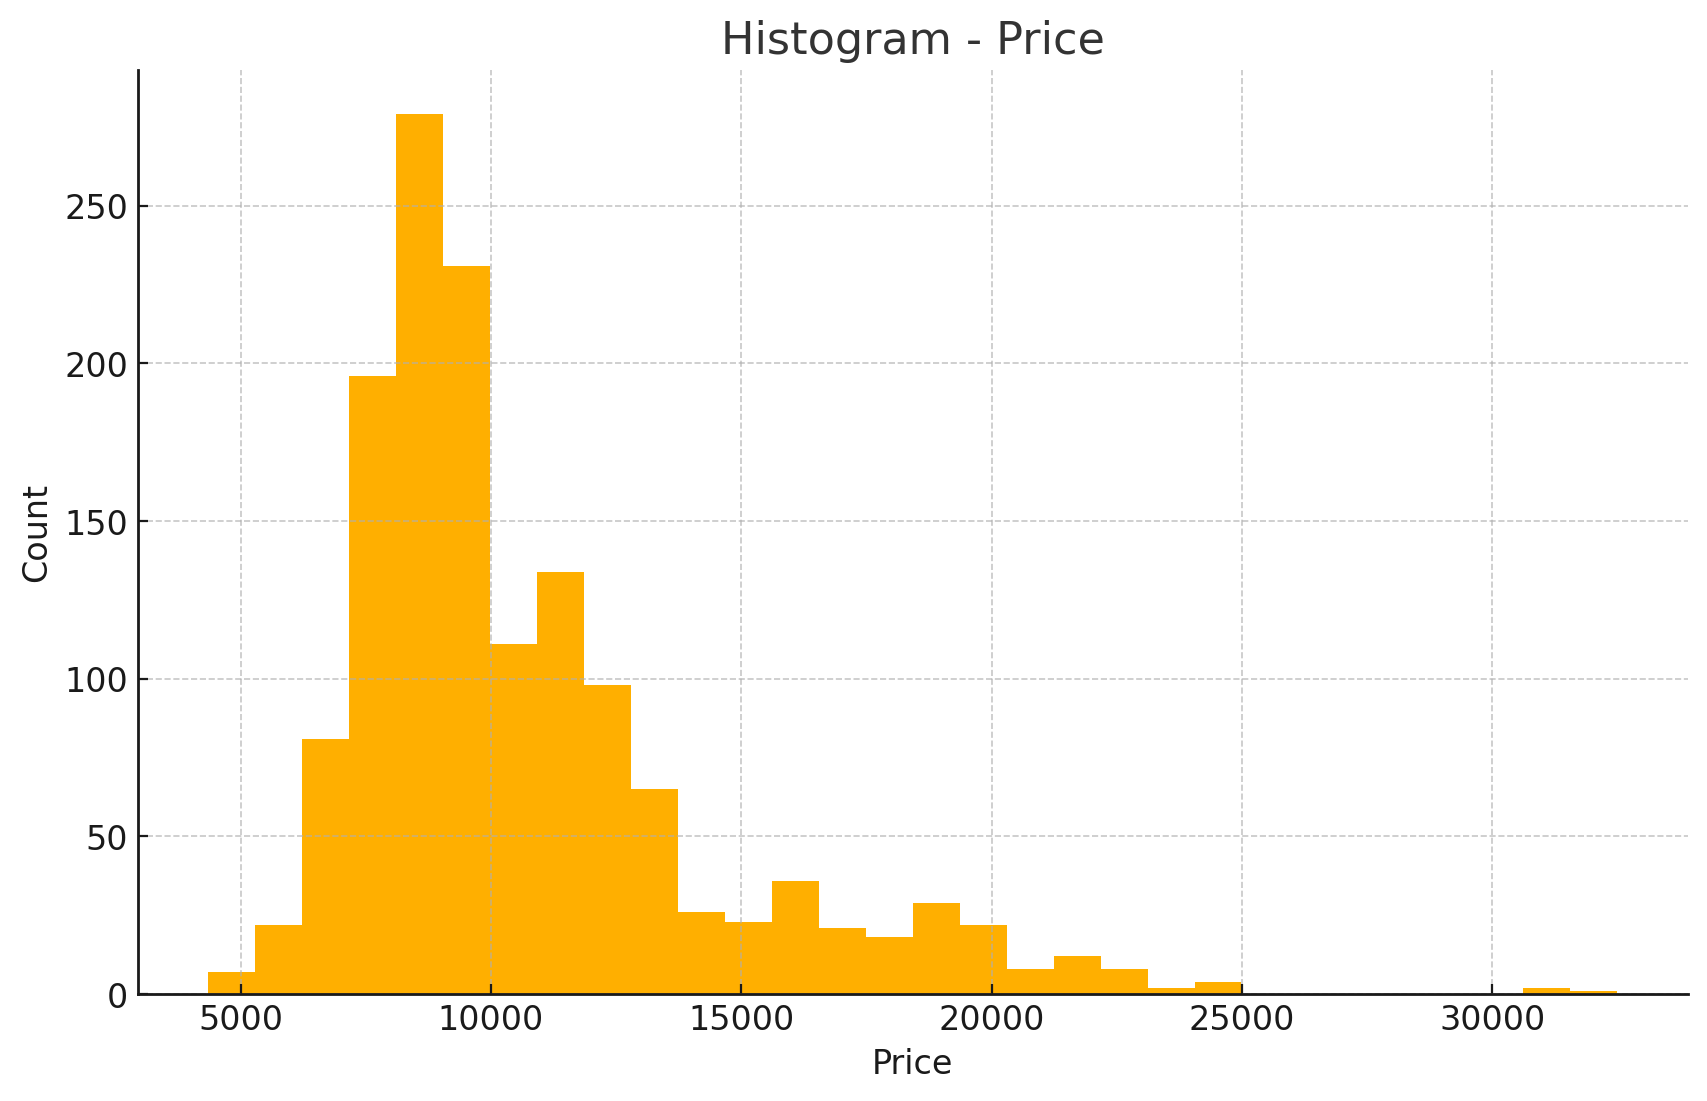

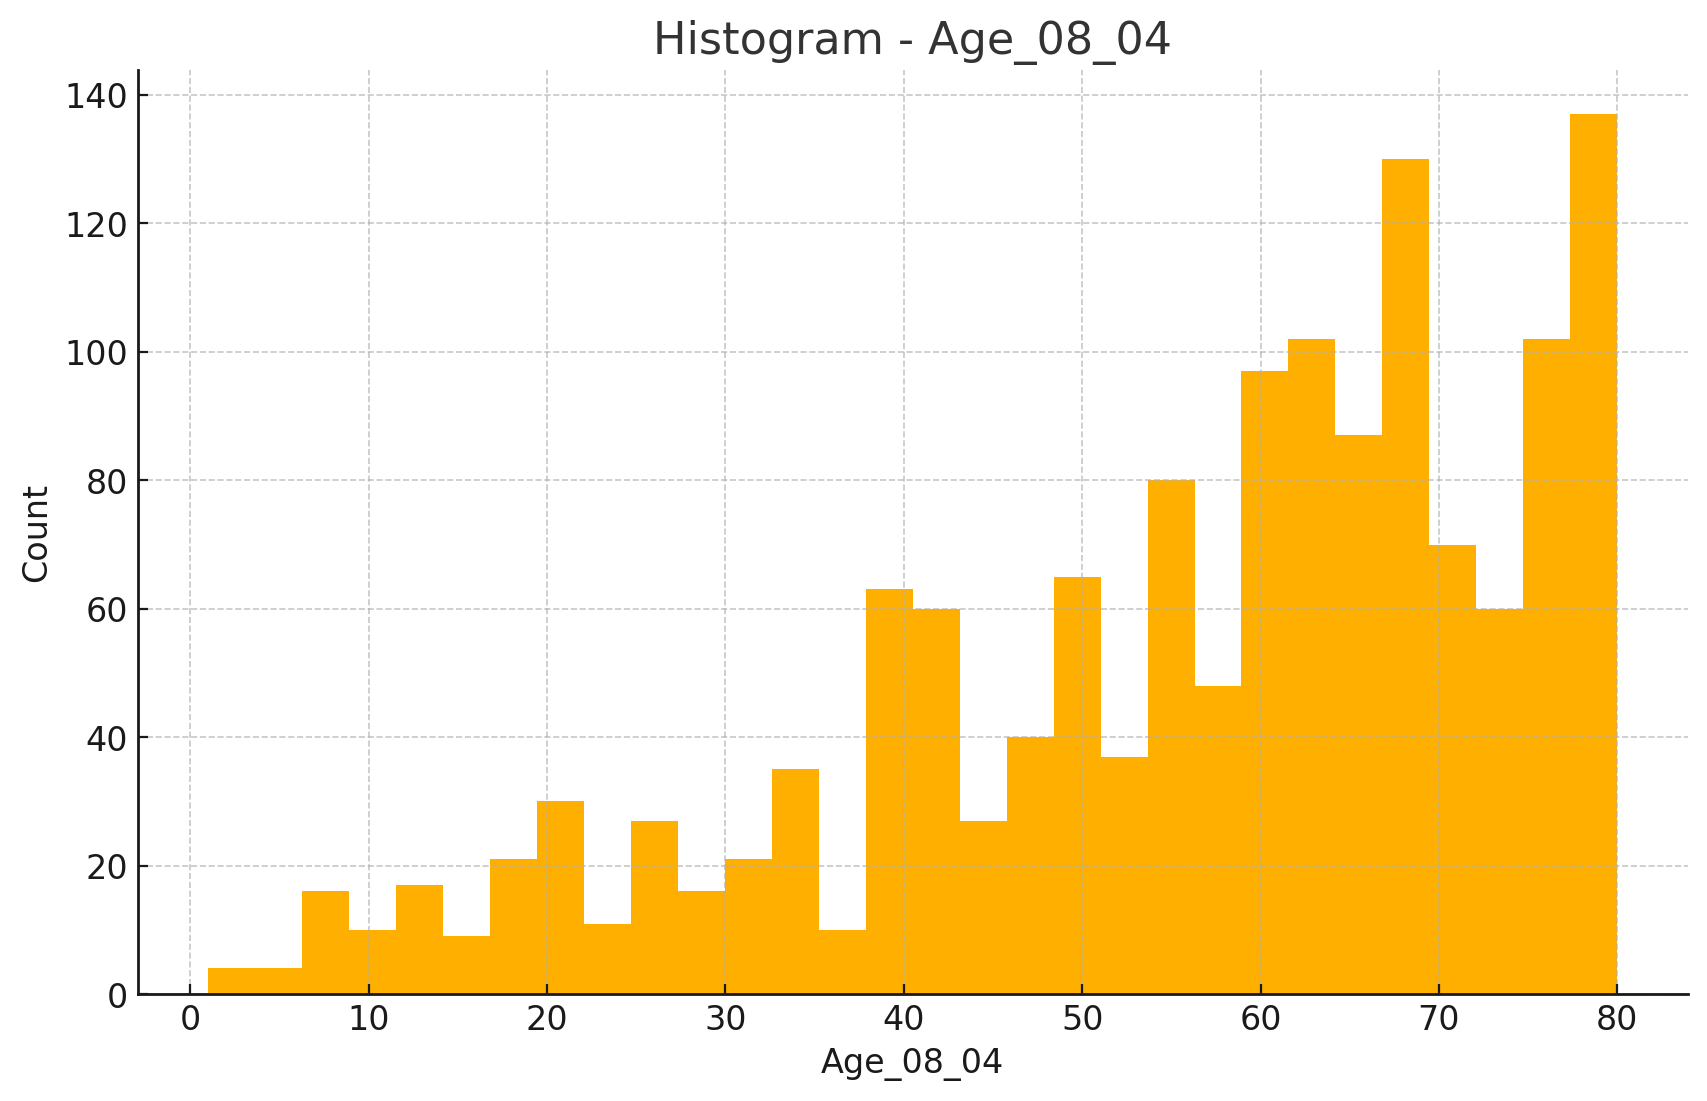

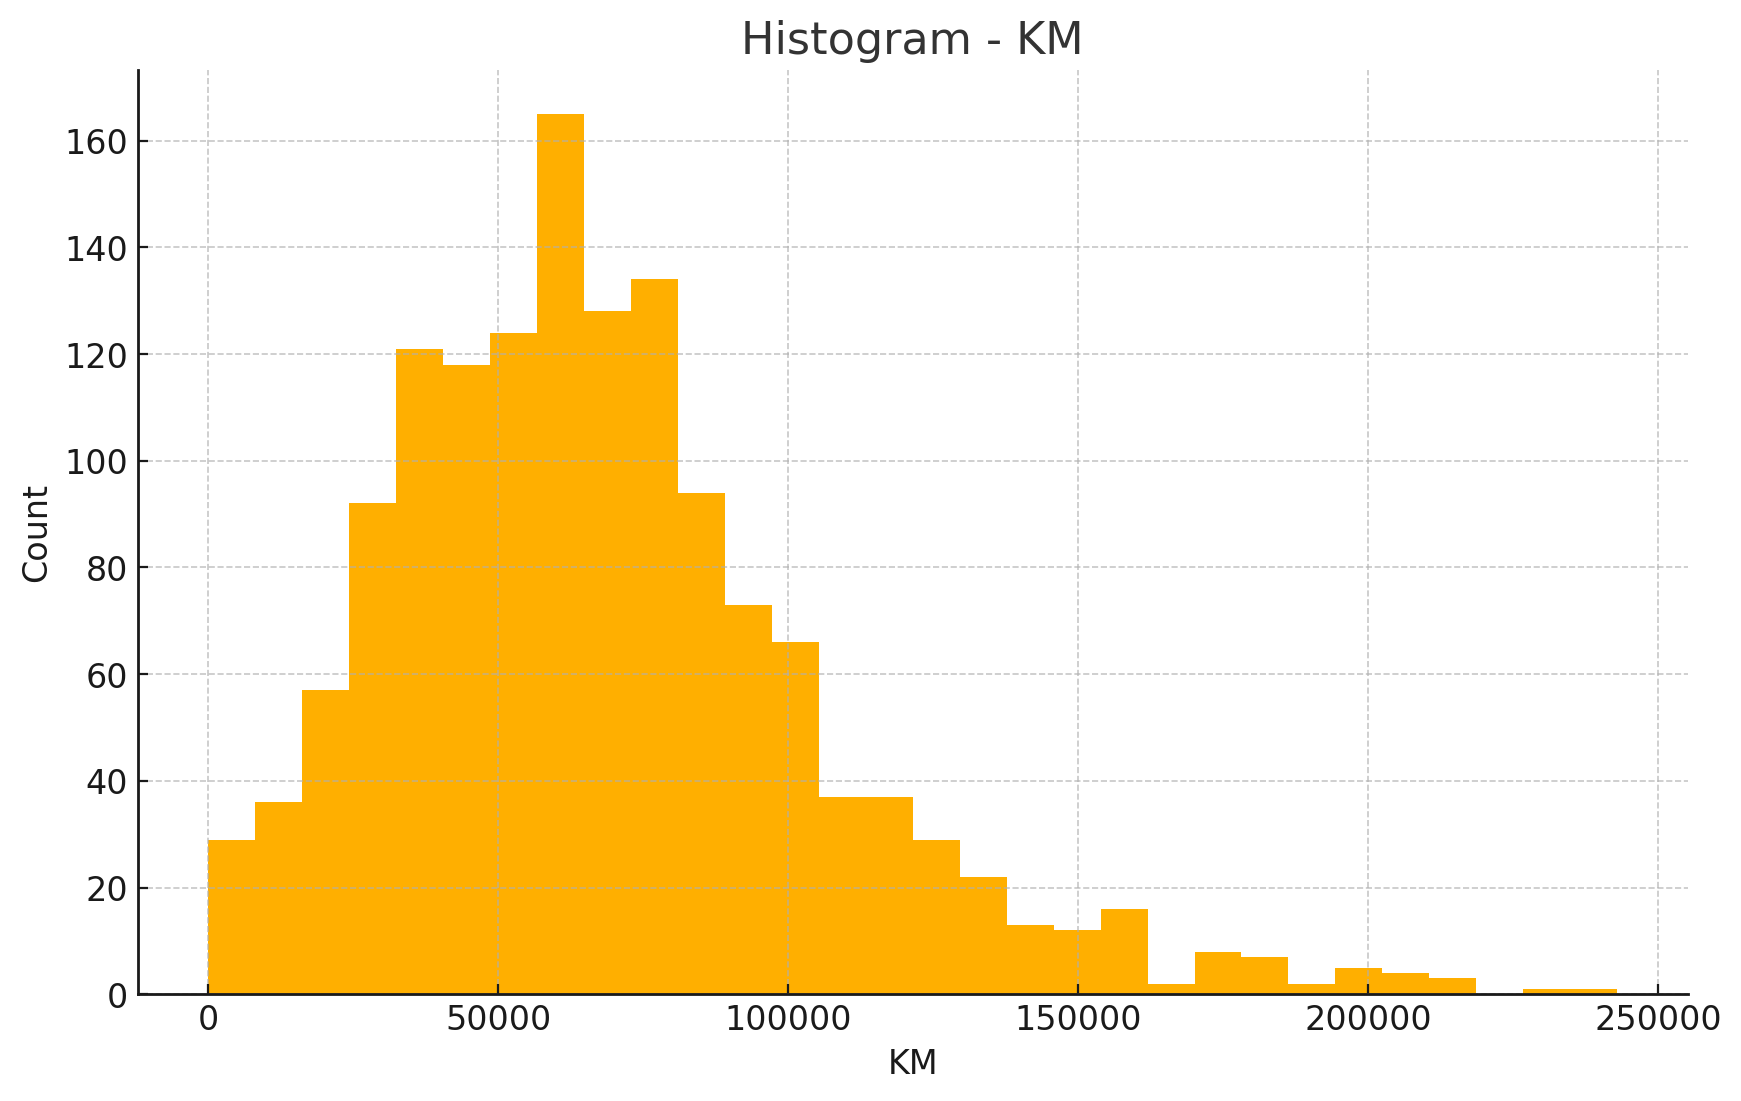

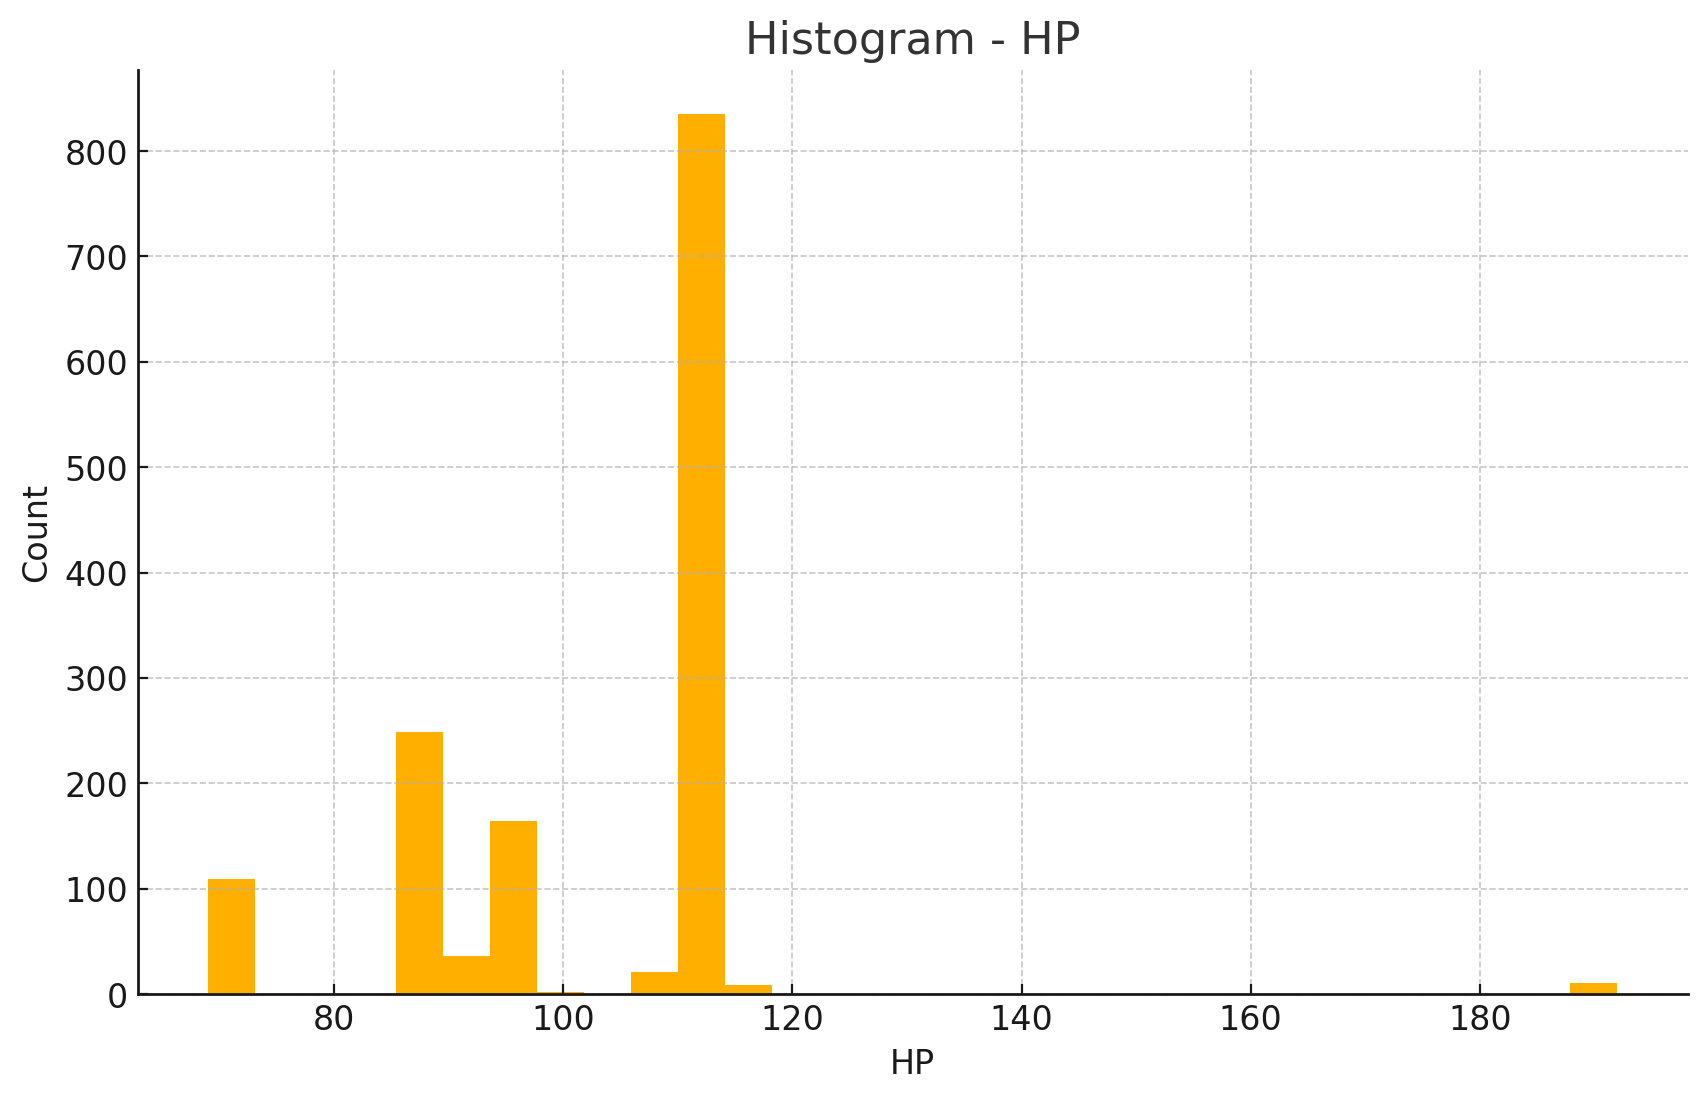

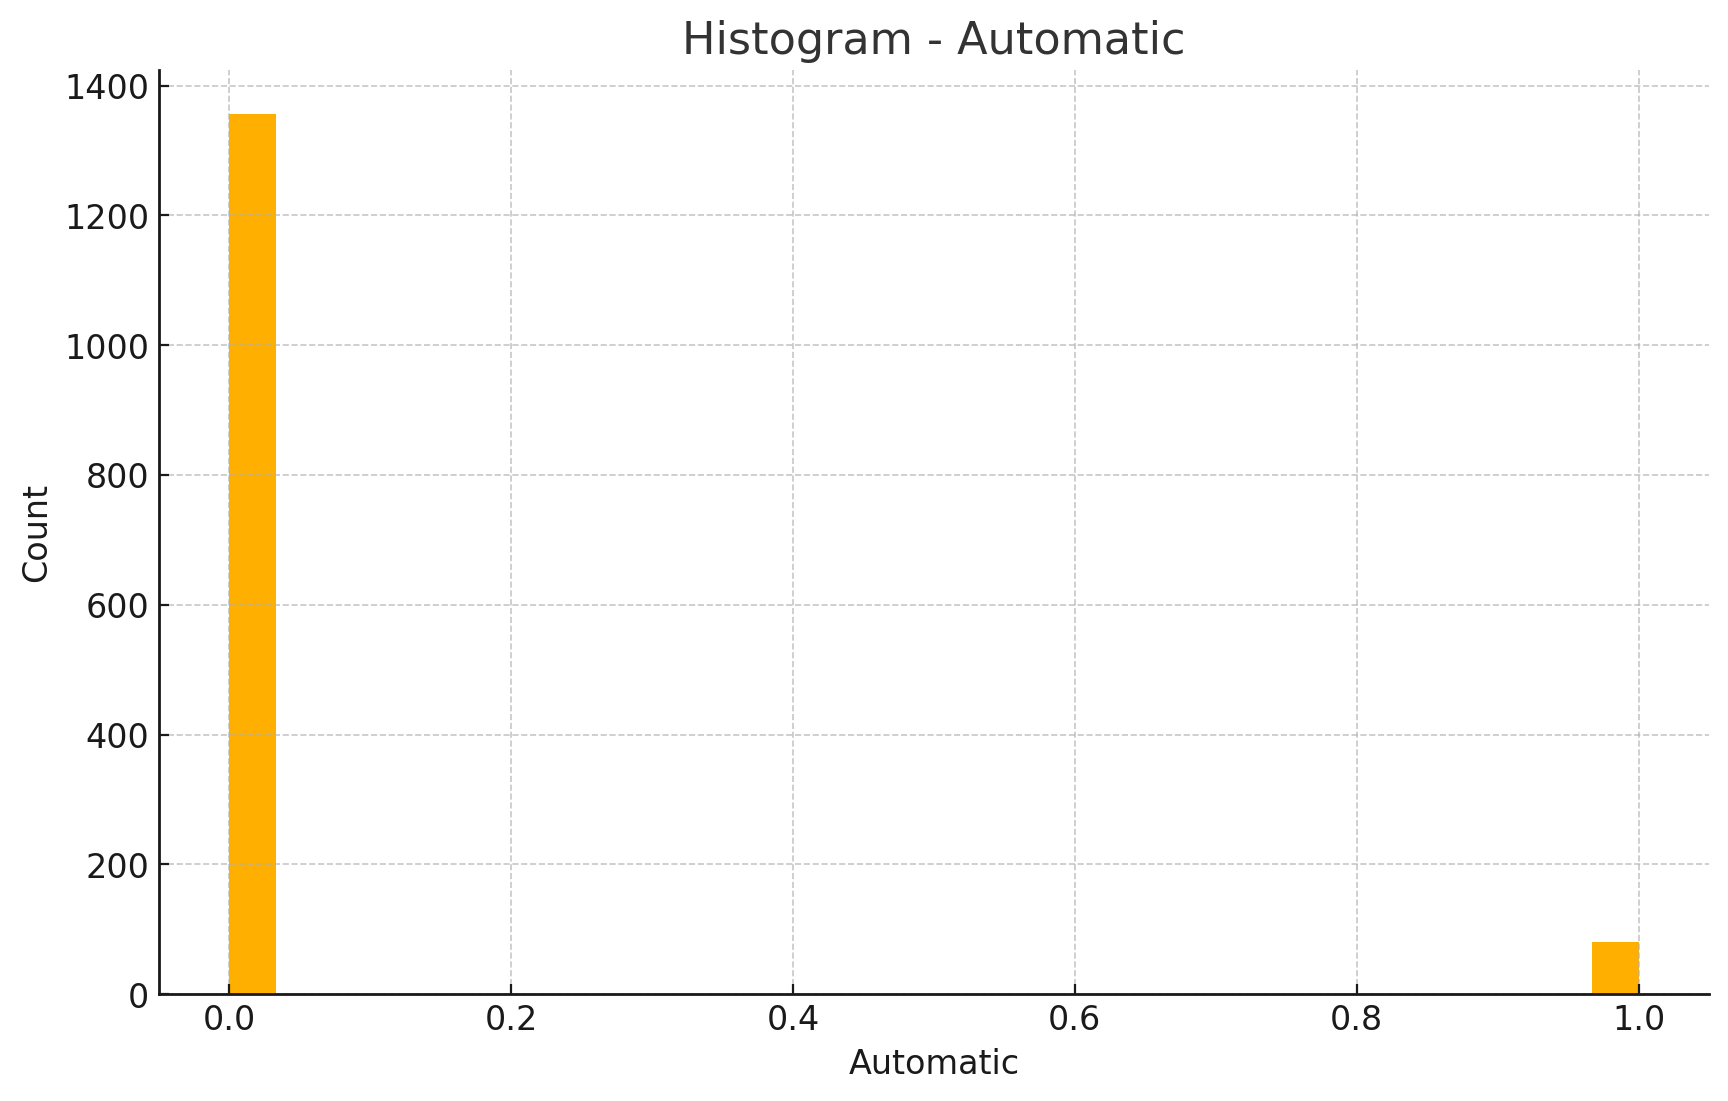

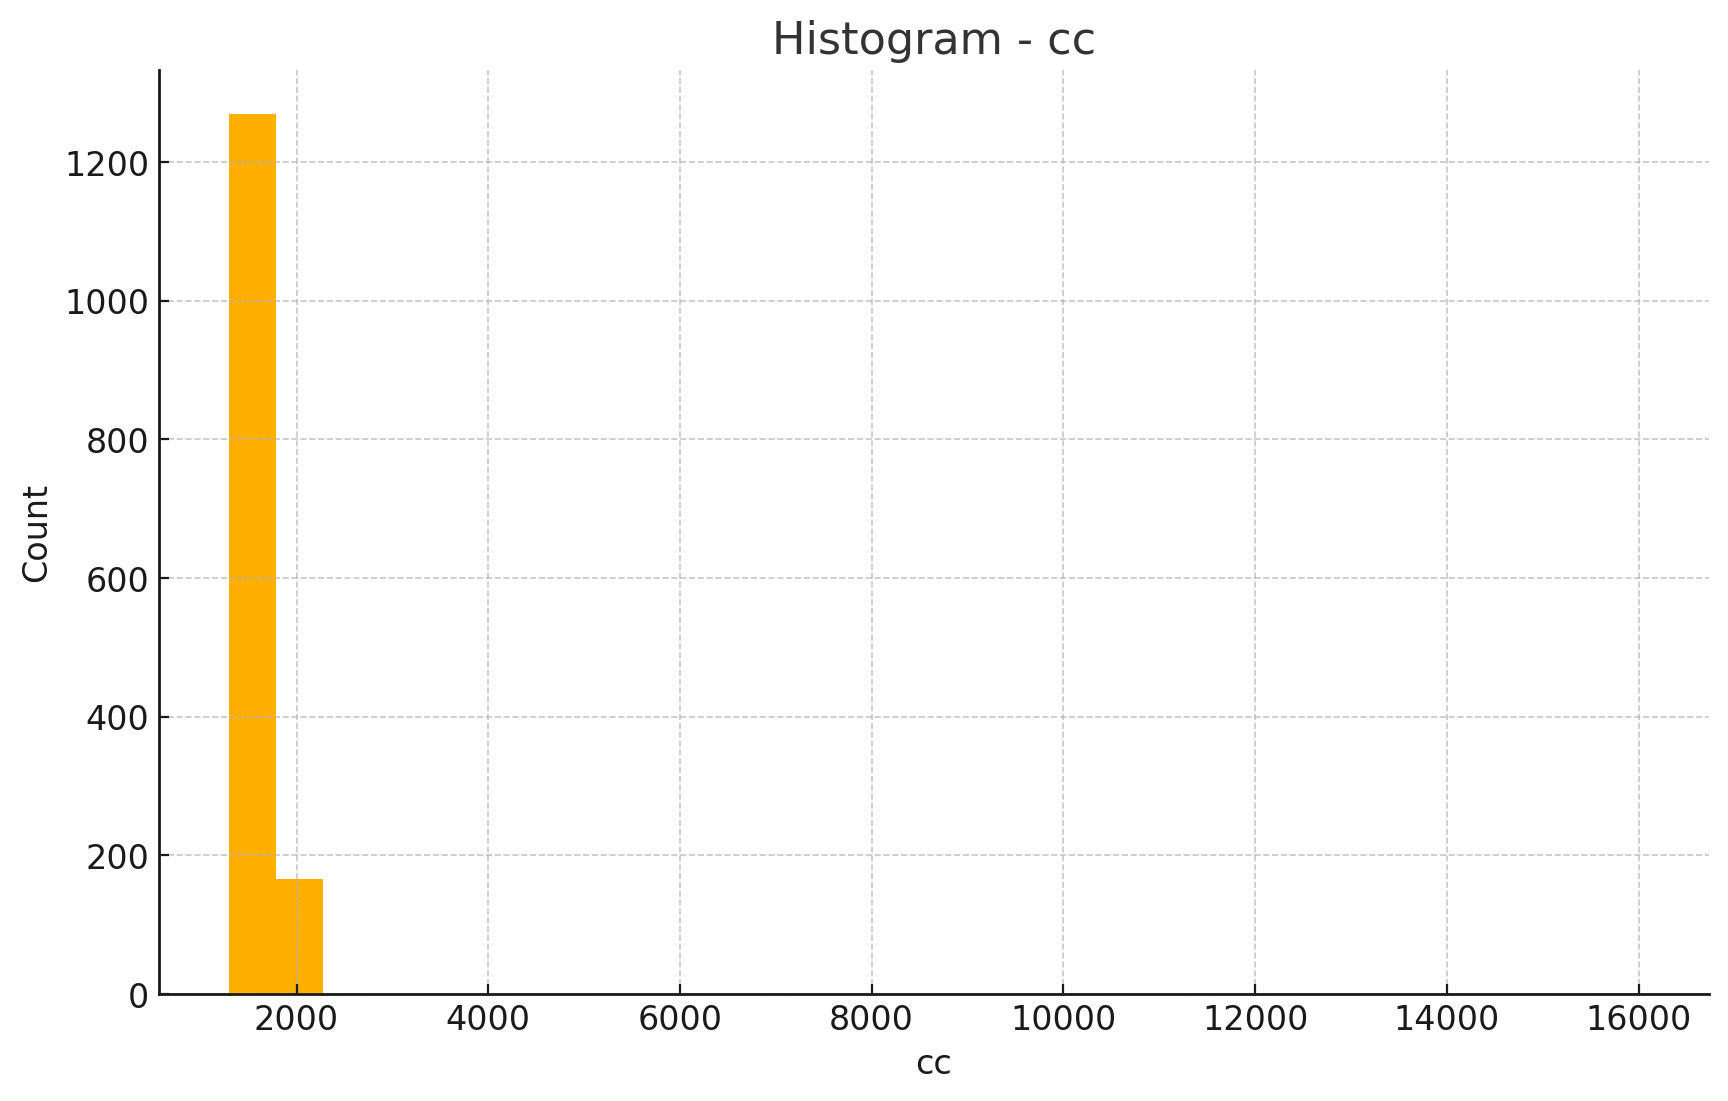

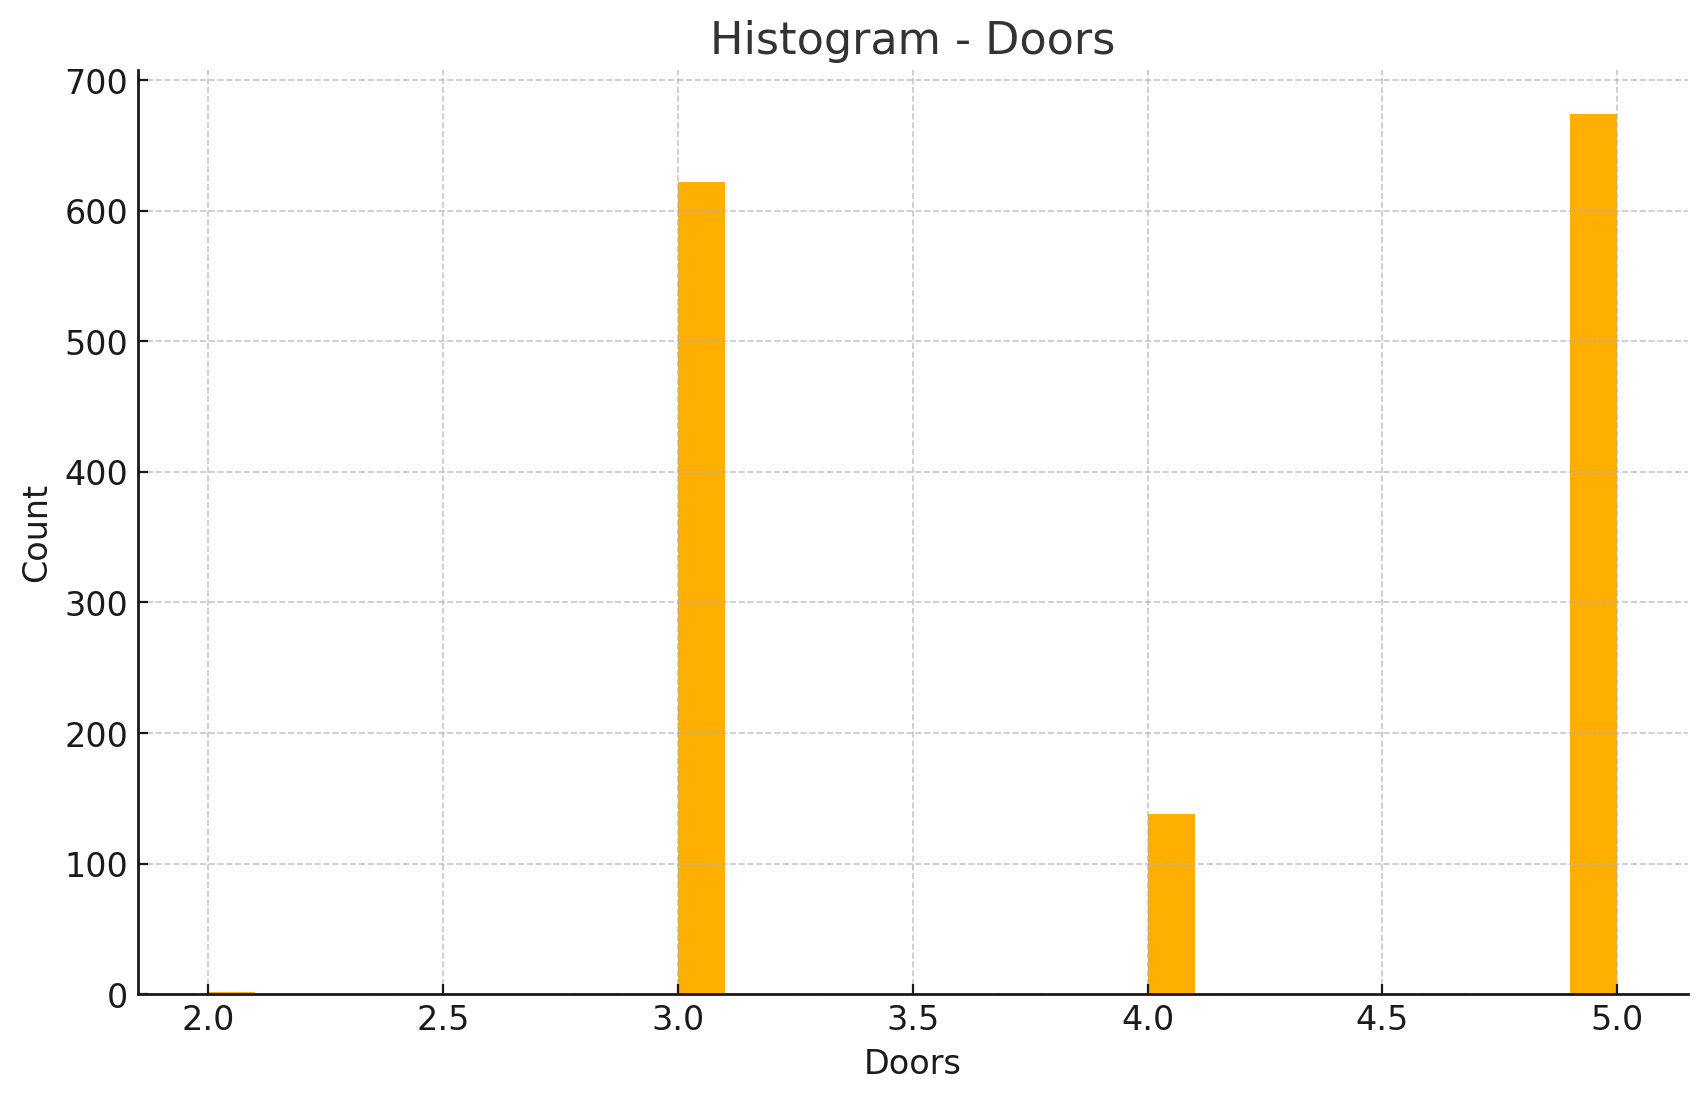

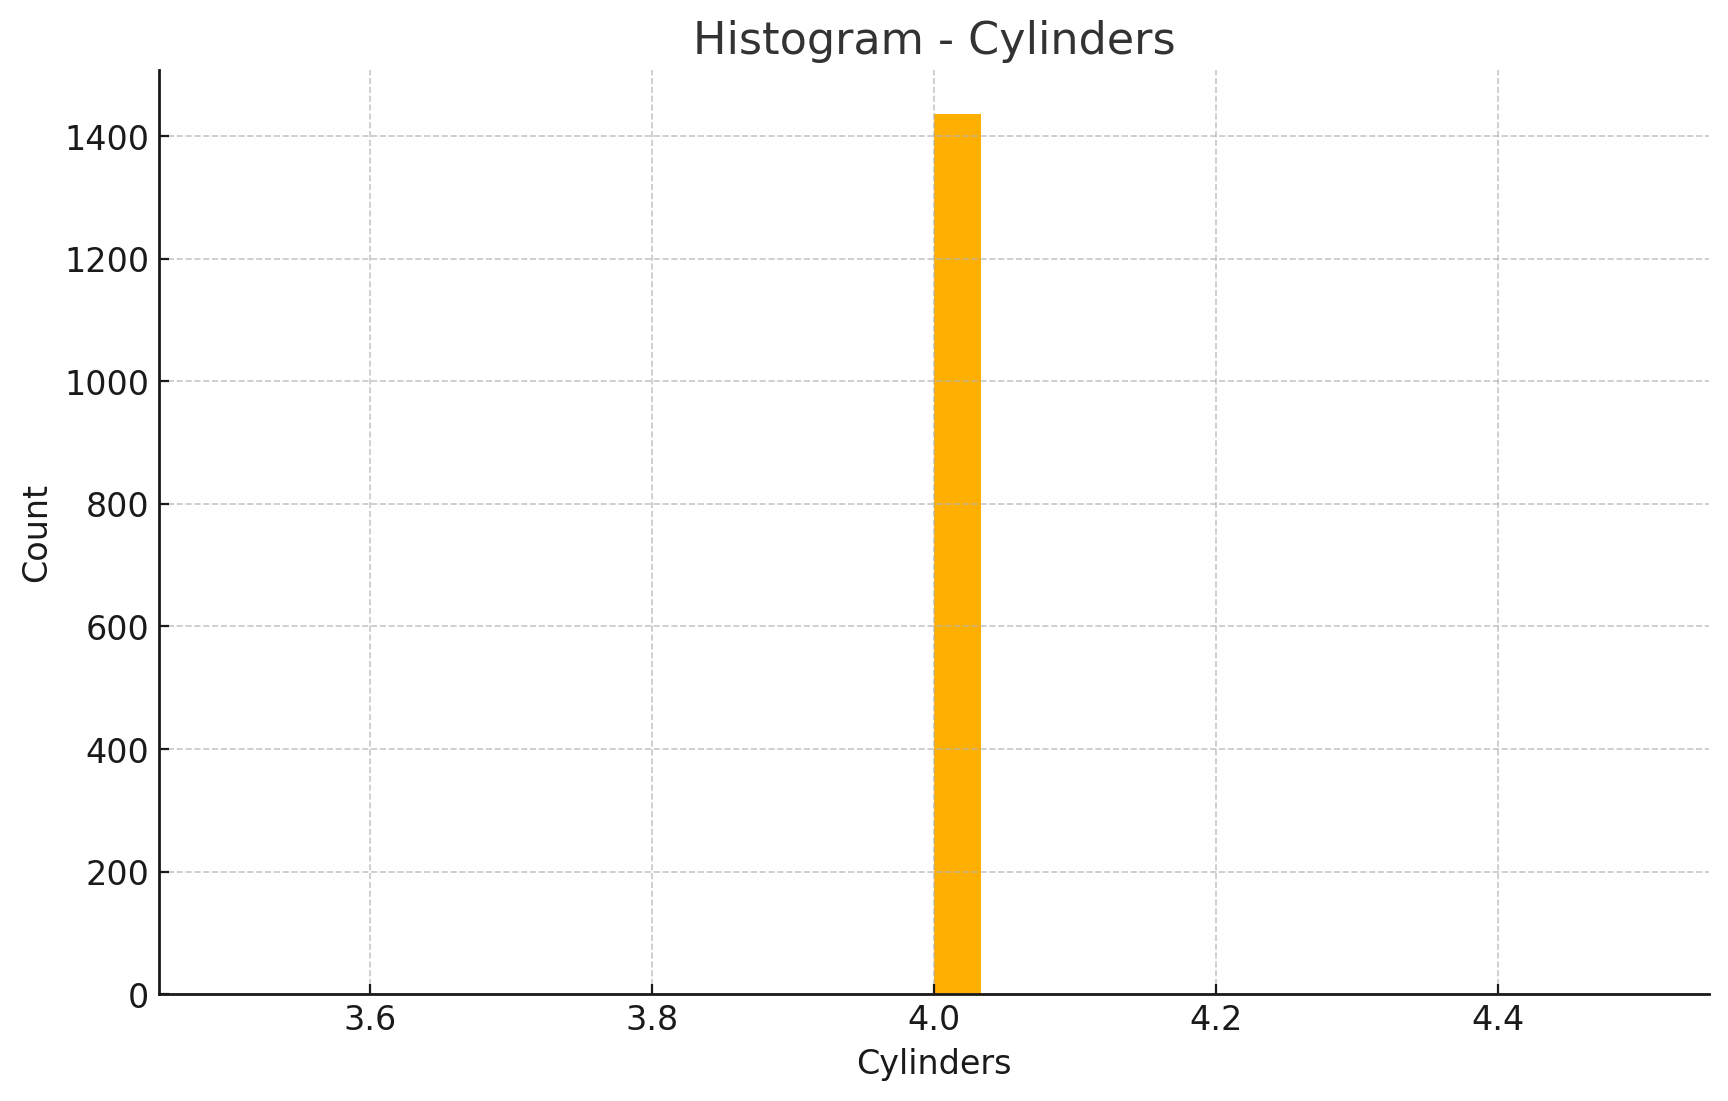

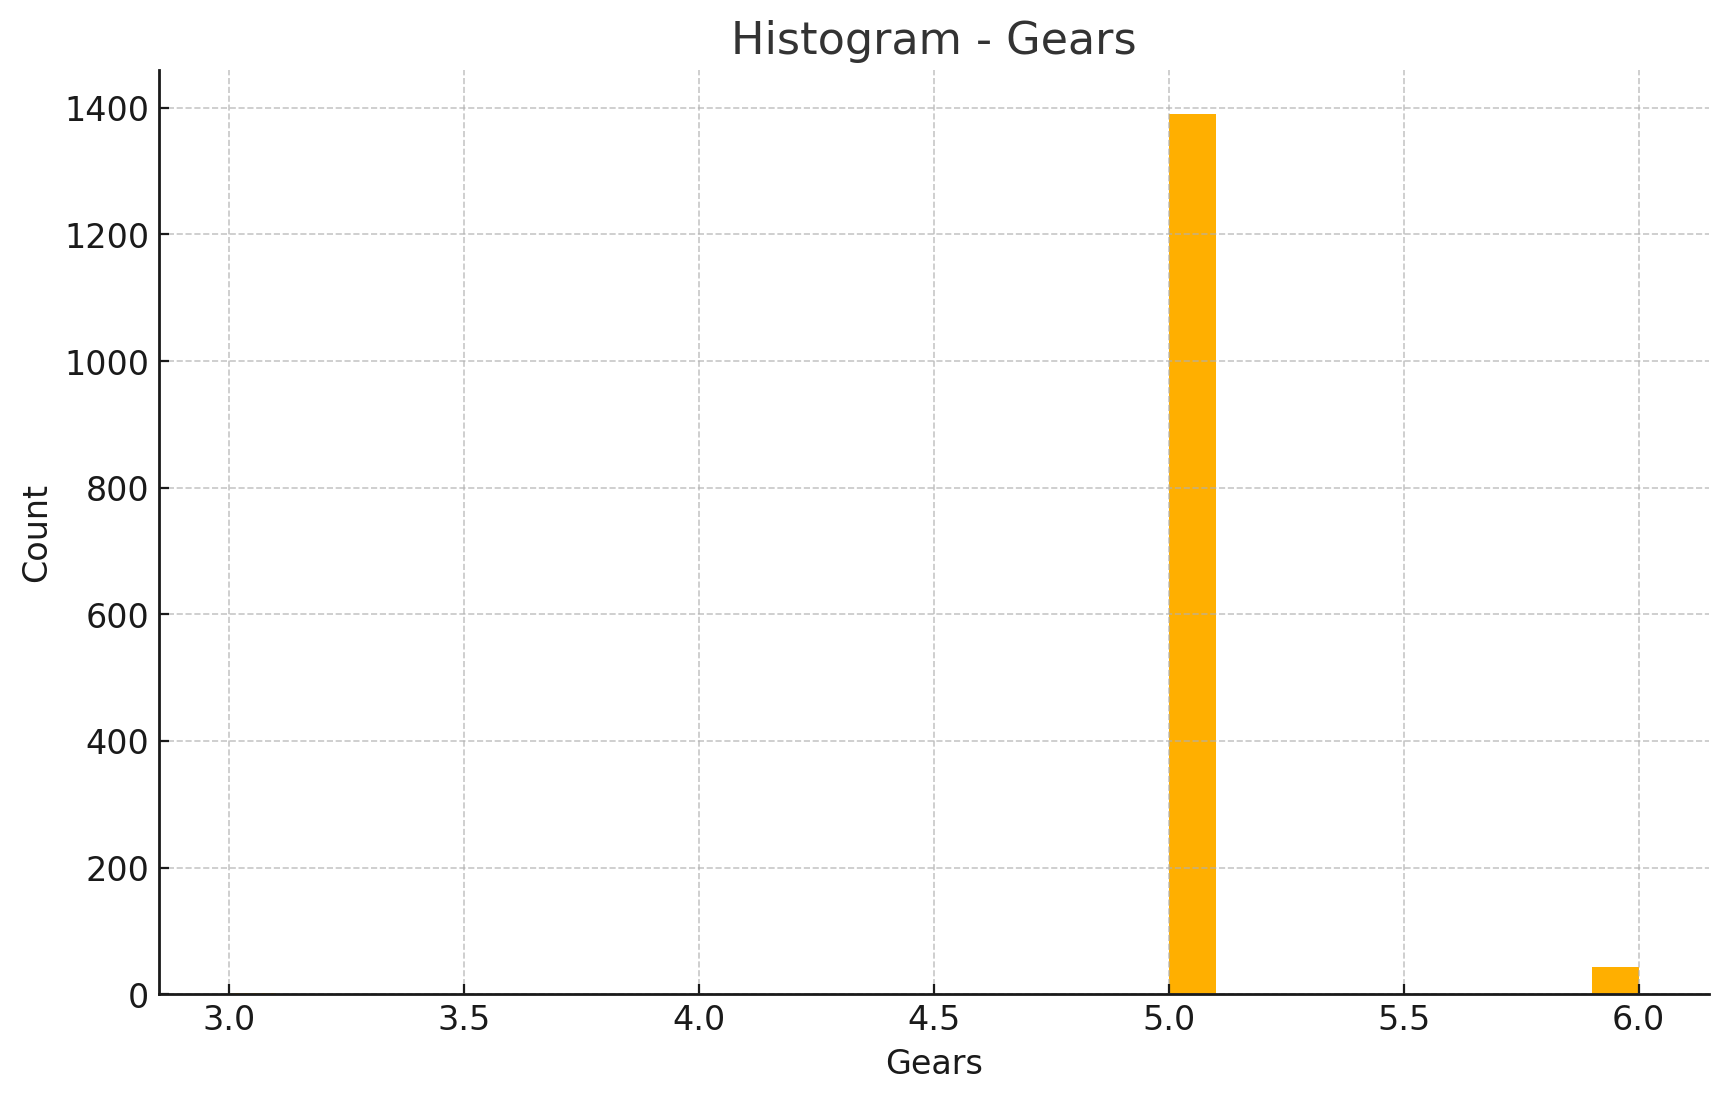

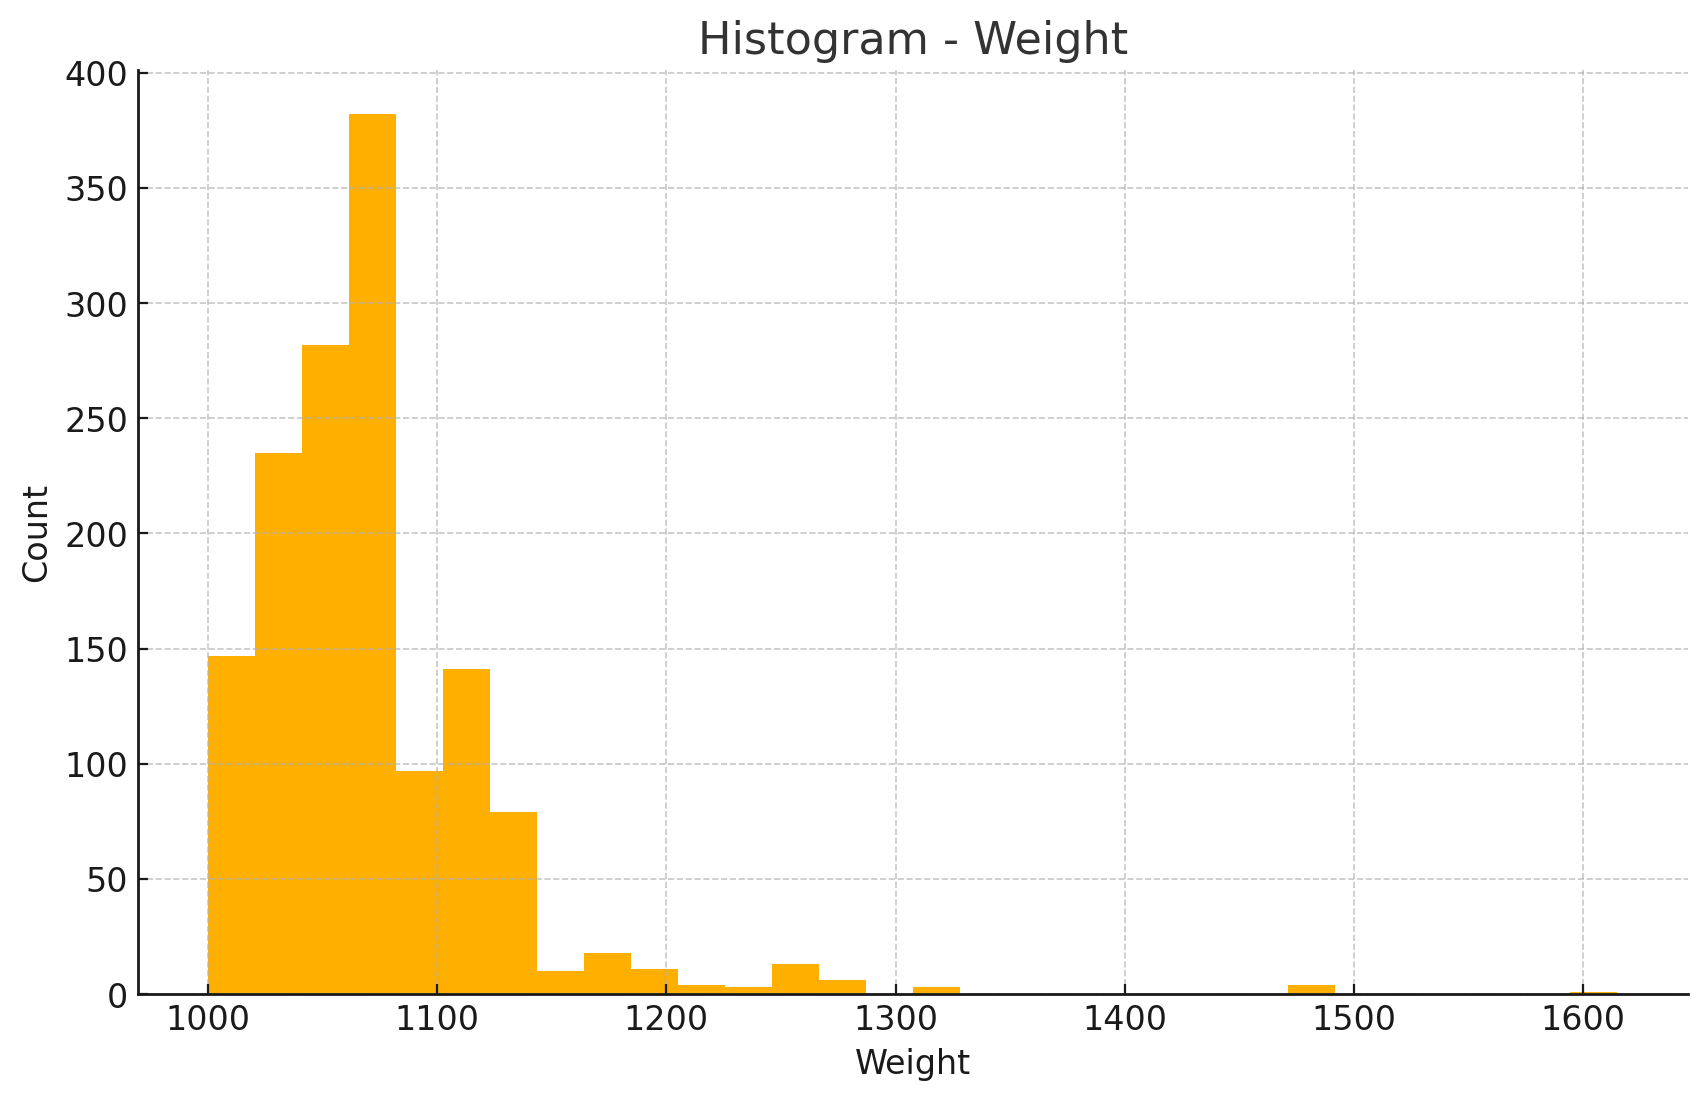

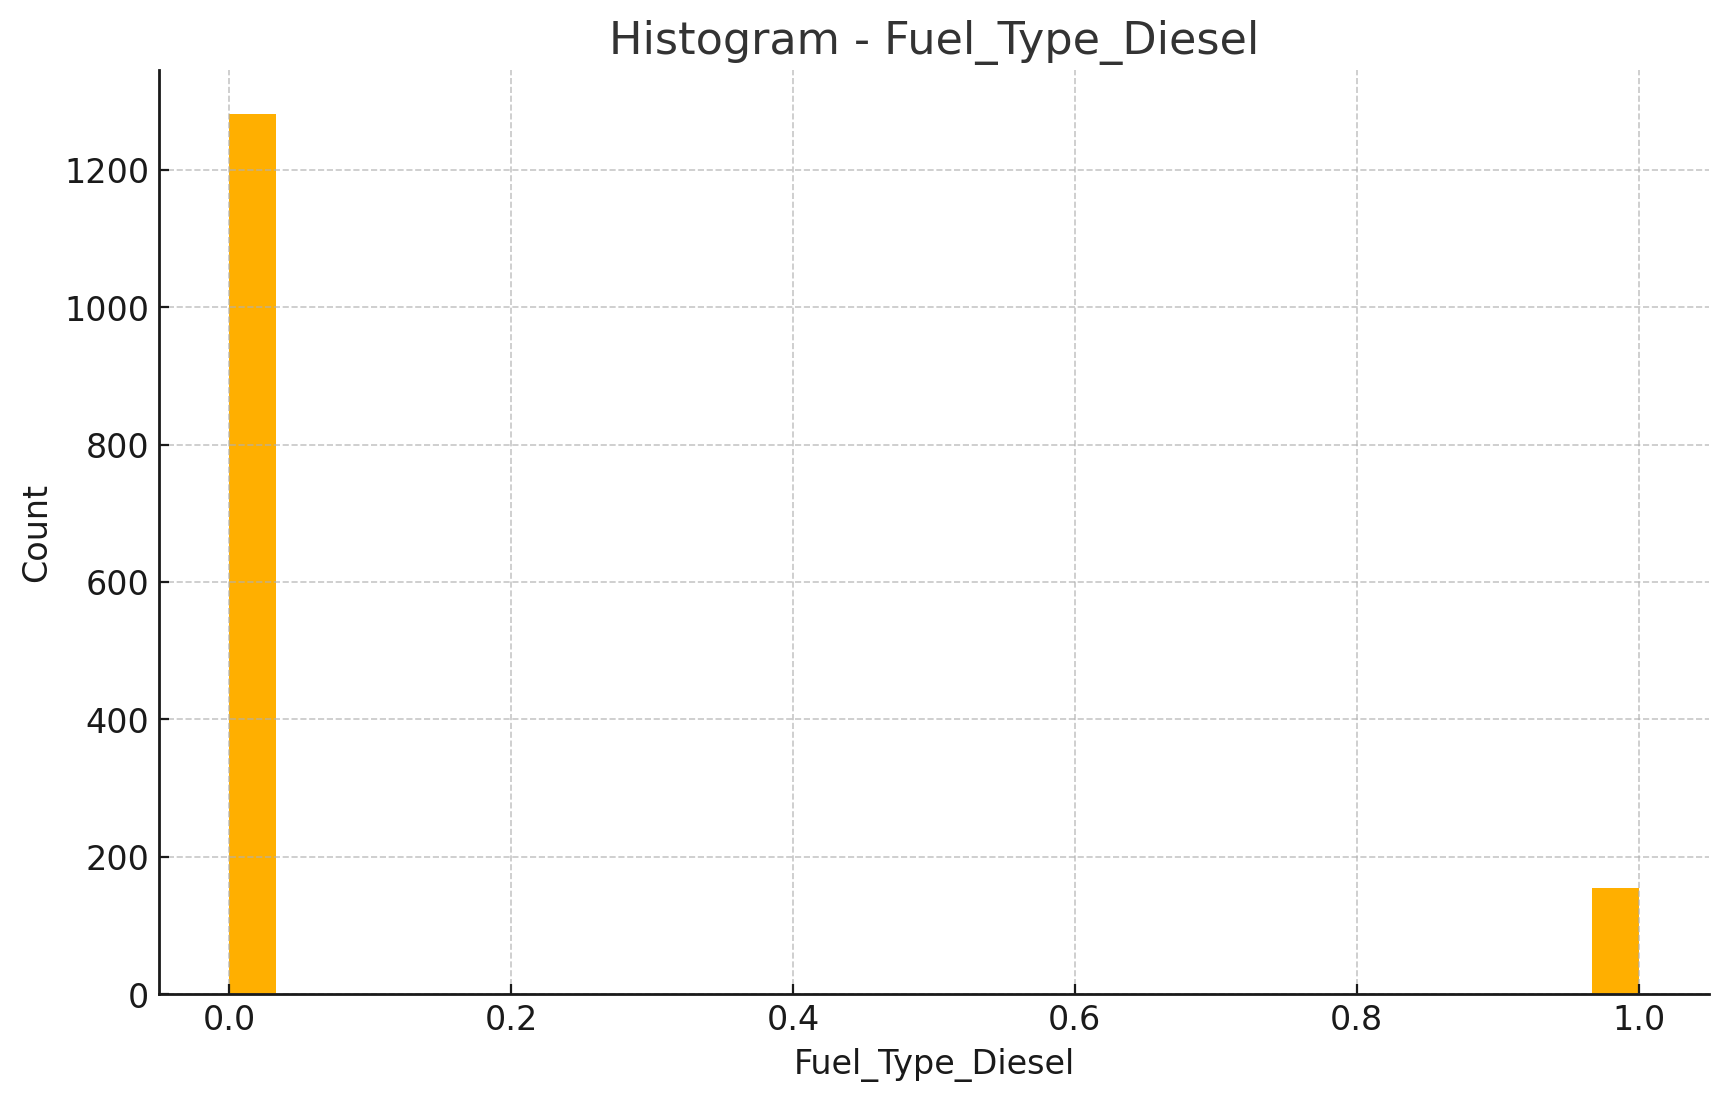

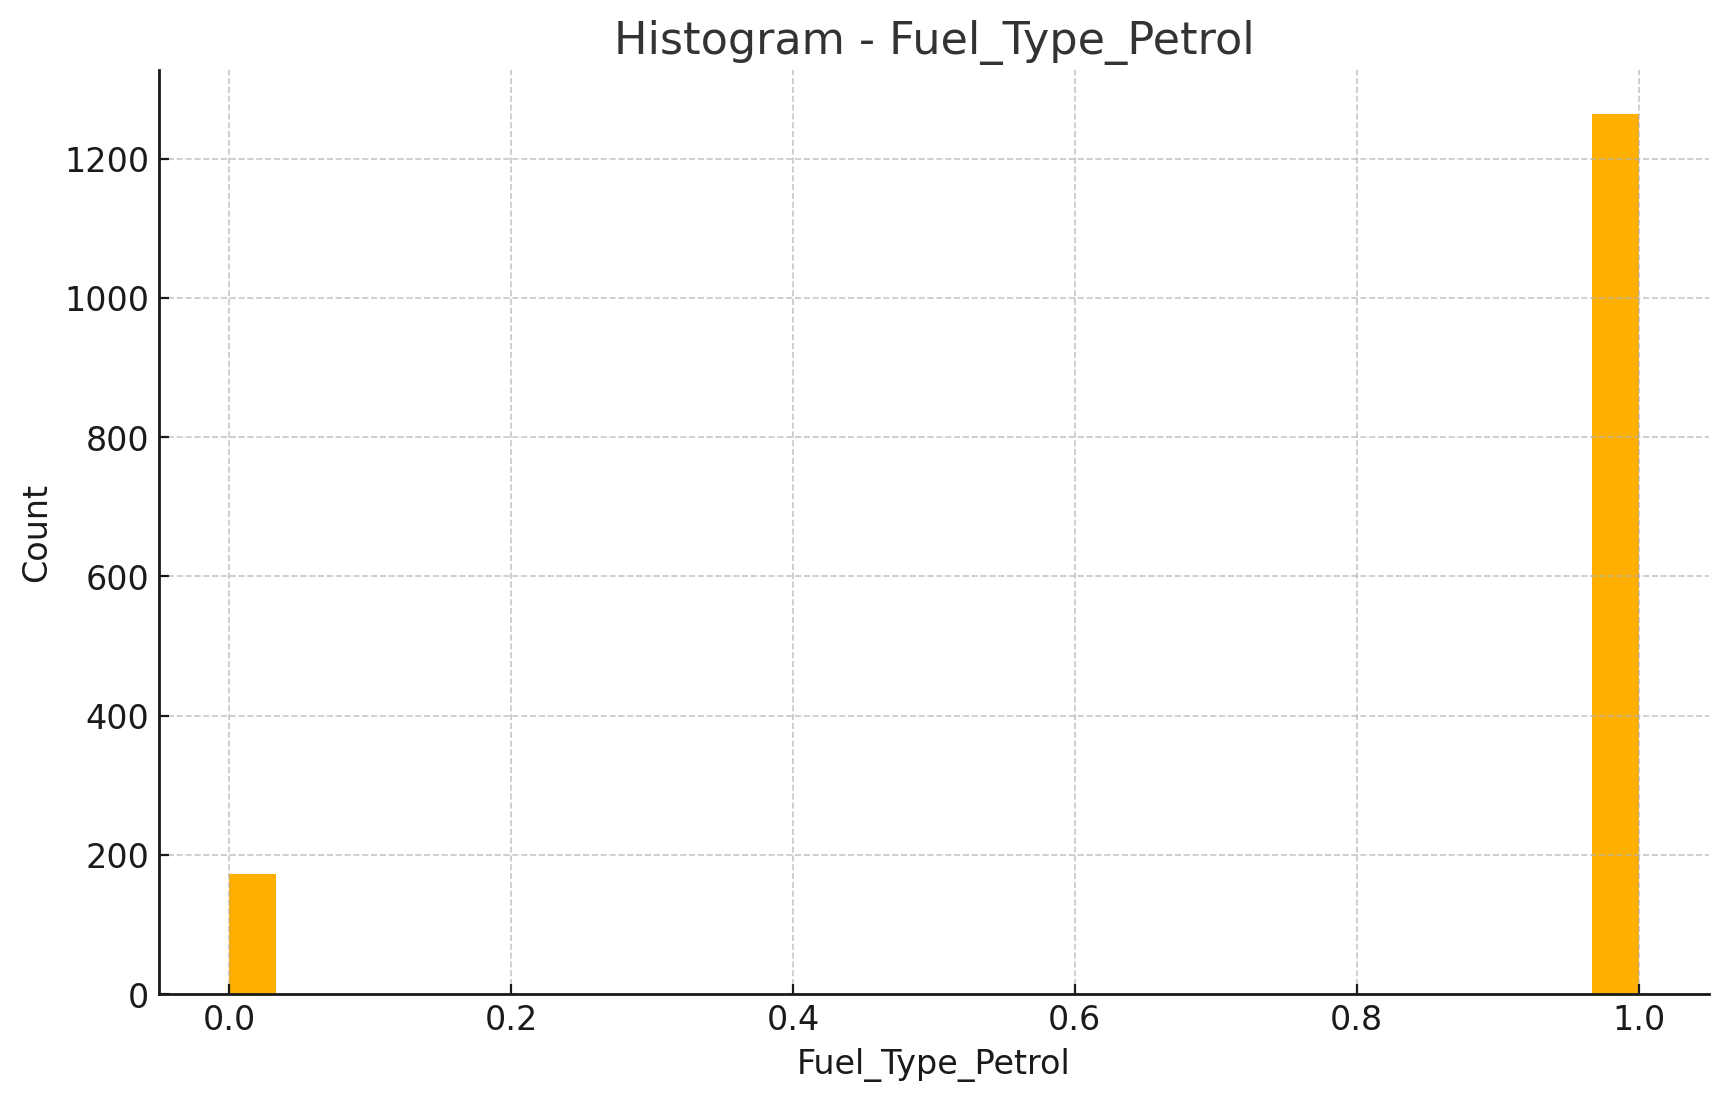

In [4]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram - {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

### Correlation heatmap (numerical)

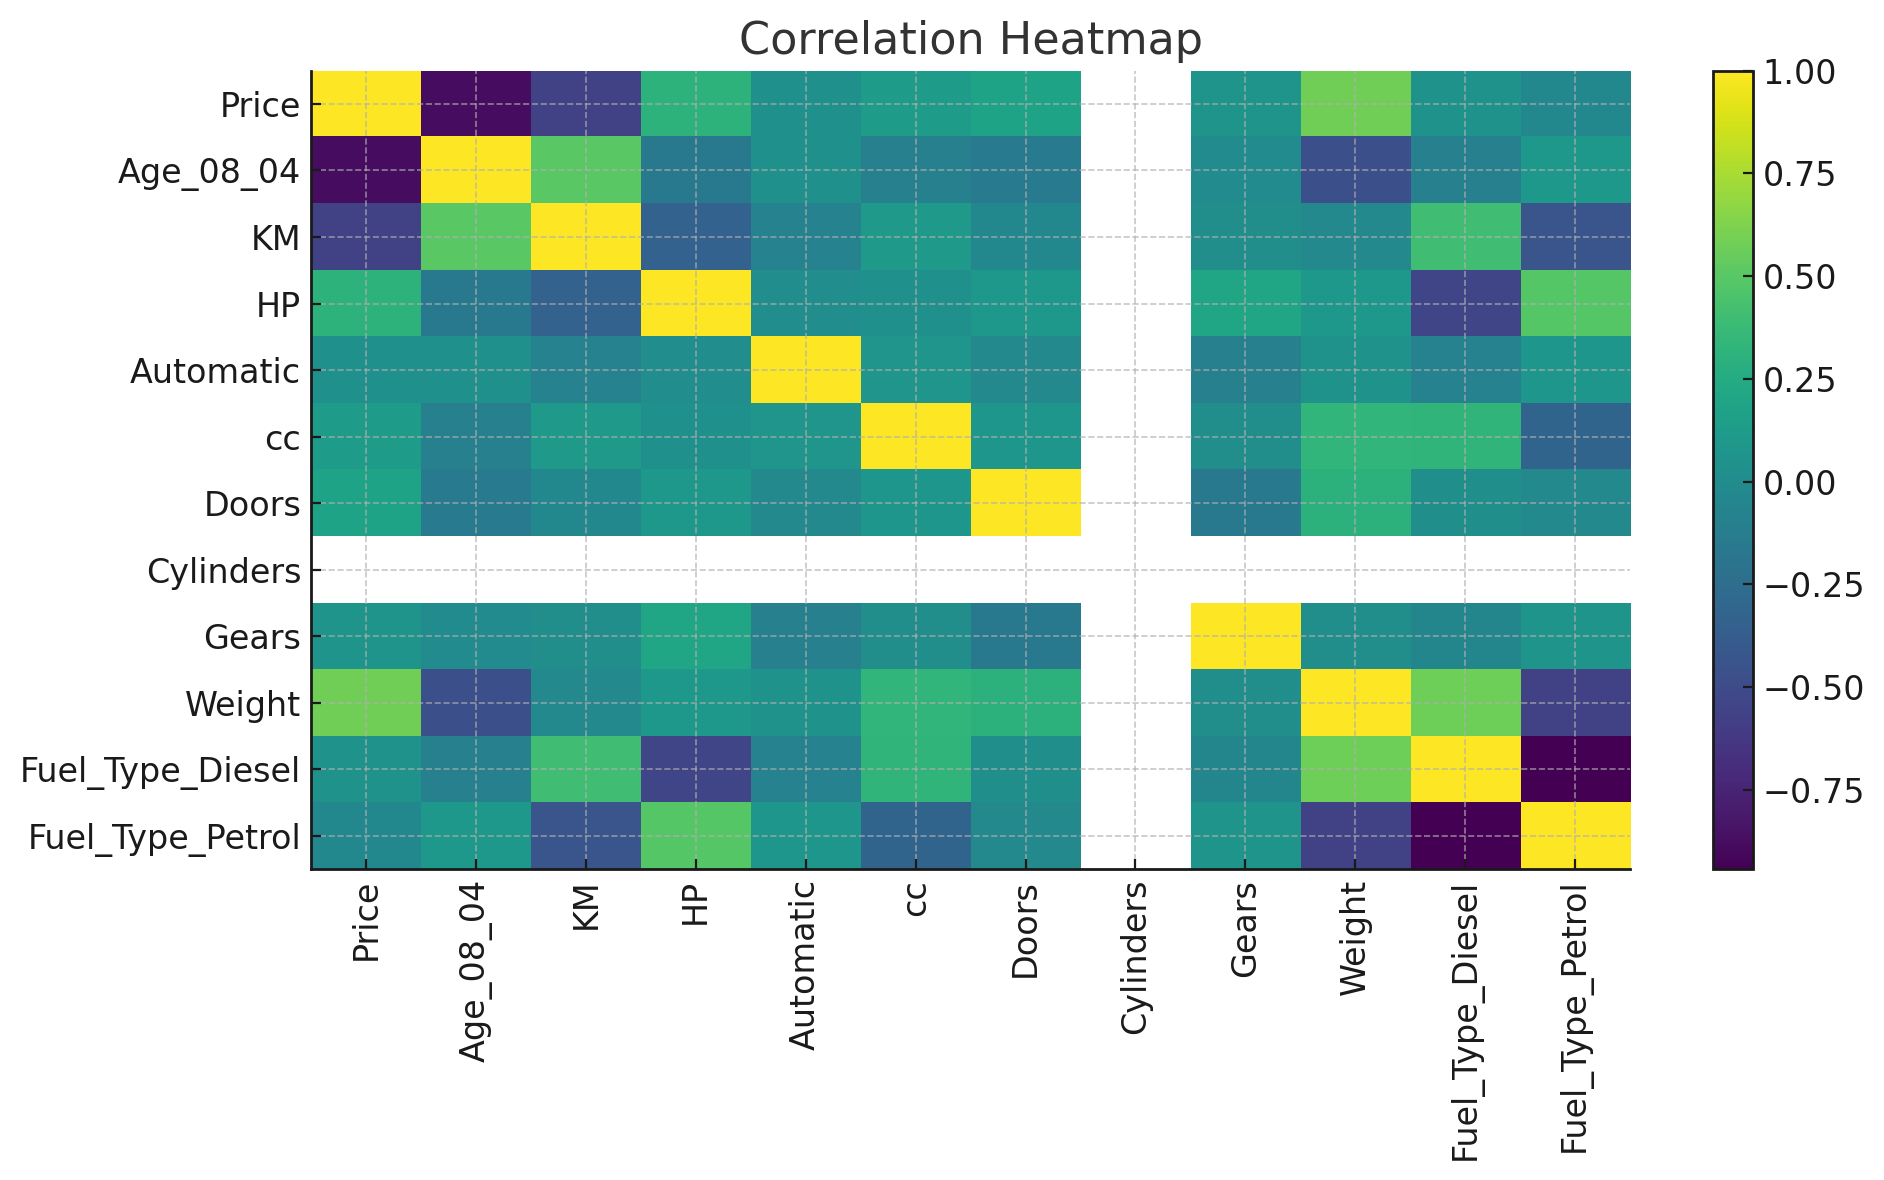

In [5]:
corr = df[num_cols].corr()
plt.figure()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

## 3) Preprocessing
- Handle categorical `FuelType` via one-hot
- Confirm numeric types
- Simple imputation for any missing numeric values
- Target: `Price`

In [6]:
df_proc = df.copy()

# Ensure expected columns exist; if not, infer likely columns
expected = ['Age','KM','FuelType','HP','Automatic','CC','Doors','Weight','Quarterly_Tax','Price']
missing = [c for c in expected if c not in df_proc.columns]
print("Missing expected columns:", missing)

# Cast numeric columns
for c in ['Age','KM','HP','Automatic','CC','Doors','Weight','Quarterly_Tax','Price']:
    if c in df_proc.columns:
        df_proc[c] = pd.to_numeric(df_proc[c], errors='coerce')

# One-hot encode FuelType if present
if 'FuelType' in df_proc.columns:
    df_proc = pd.get_dummies(df_proc, columns=['FuelType'], drop_first=True)

# Simple numeric imputation with median
for c in df_proc.select_dtypes(include=[np.number]).columns:
    df_proc[c] = df_proc[c].fillna(df_proc[c].median())

print("Final columns:", df_proc.columns.tolist())
df_proc.head()

Missing expected columns: ['Age', 'FuelType', 'CC', 'Quarterly_Tax']
Final columns: ['Price', 'Age_08_04', 'KM', 'HP', 'Automatic', 'cc', 'Doors', 'Cylinders', 'Gears', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol']


,Price,Age_08_04,KM,HP,Automatic,cc,Doors,Cylinders,Gears,Weight,Fuel_Type_Diesel,Fuel_Type_Petrol
0,13500,23,46986,90,0,2000,3,4,5,1165,1,0
1,13750,23,72937,90,0,2000,3,4,5,1165,1,0
2,13950,24,41711,90,0,2000,3,4,5,1165,1,0
3,14950,26,48000,90,0,2000,3,4,5,1165,1,0
4,13750,30,38500,90,0,2000,3,4,5,1170,1,0


## 4) Train/Test split

In [7]:
from sklearn.model_selection import train_test_split

y = df_proc['Price']
X = df_proc.drop(columns=['Price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1148, 11), (288, 11))

## 5) Model 1 — Baseline Linear Regression (all features)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

lin1 = LinearRegression()
lin1.fit(X_train, y_train)
pred1 = lin1.predict(X_test)

rmse1 = mean_squared_error(y_test, pred1, squared=False)
mae1 = mean_absolute_error(y_test, pred1)
r21 = r2_score(y_test, pred1)

print("RMSE:", rmse1)
print("MAE :", mae1)
print("R^2 :", r21)

RMSE: 1484.2654153296508
MAE : 990.8872739193923
R^2 : 0.8348888040611084


## 6) Model 2 — Address Multicollinearity (VIF-based feature reduction)

In [9]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(dfX):
    dfX_ = dfX.copy()
    dfX_ = dfX_.assign(_const_=1.0)  # to avoid intercept issues
    vif = []
    cols = dfX.columns.tolist()
    for i in range(len(cols)):
        vif_val = variance_inflation_factor(dfX_.values, i)
        vif.append(vif_val)
    return pd.DataFrame({'feature': cols, 'VIF': vif}).sort_values('VIF', ascending=False)

vif_table = compute_vif(X_train)
vif_table

/home/sandbox/.local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,feature,VIF
9,Fuel_Type_Diesel,10.308831
10,Fuel_Type_Petrol,8.435396
8,Weight,3.880178
2,HP,2.390991
1,KM,2.049863
0,Age_08_04,1.963717
5,Doors,1.227924
4,cc,1.194085
3,Automatic,1.122540
7,Gears,1.116589


In [10]:
# Drop features with very high VIF iteratively (>10 threshold as a rule of thumb)
X_train_vif = X_train.copy()
X_test_vif = X_test.copy()

while True:
    vif_tab = []
    try:
        vif_tab = (lambda dfX: pd.DataFrame({
            'feature': dfX.columns,
            'VIF': [variance_inflation_factor(np.column_stack([dfX.values, np.ones(len(dfX))]), i)
                    for i in range(dfX.shape[1])]
        }))(X_train_vif)
    except Exception as e:
        print("VIF computation issue:", e)
        break

    high = vif_tab[vif_tab['VIF']>10]
    if high.empty:
        break
    # Remove the single highest VIF feature
    drop_feat = high.sort_values('VIF', ascending=False).iloc[0]['feature']
    print("Dropping due to high VIF:", drop_feat)
    X_train_vif = X_train_vif.drop(columns=[drop_feat])
    X_test_vif = X_test_vif.drop(columns=[drop_feat])

lin2 = LinearRegression()
lin2.fit(X_train_vif, y_train)
pred2 = lin2.predict(X_test_vif)

rmse2 = mean_squared_error(y_test, pred2, squared=False)
mae2 = mean_absolute_error(y_test, pred2)
r22 = r2_score(y_test, pred2)

print("Features used:", X_train_vif.columns.tolist())
print("RMSE:", rmse2)
print("MAE :", mae2)
print("R^2 :", r22)

/home/sandbox/.local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping due to high VIF: Fuel_Type_Diesel
Features used: ['Age_08_04', 'KM', 'HP', 'Automatic', 'cc', 'Doors', 'Cylinders', 'Gears', 'Weight', 'Fuel_Type_Petrol']
RMSE: 1482.585606069788
MAE : 991.0188624566322
R^2 : 0.8352623199637252


/home/sandbox/.local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


## 7) Model 3 — Simple Feature Engineering (log-transforms on skewed predictors)

In [11]:
X_fe = X.copy()

# Add log transforms for KM and Age where positive
for c in ['KM','Age','CC','Weight']:
    if c in X_fe.columns:
        X_fe[f'log_{c}'] = np.log1p(X_fe[c].clip(lower=0))

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y, test_size=0.2, random_state=42)

lin3 = LinearRegression()
lin3.fit(X_train_fe, y_train_fe)
pred3 = lin3.predict(X_test_fe)

rmse3 = mean_squared_error(y_test_fe, pred3, squared=False)
mae3 = mean_absolute_error(y_test_fe, pred3)
r23 = r2_score(y_test_fe, pred3)

print("RMSE:", rmse3)
print("MAE :", mae3)
print("R^2 :", r23)

RMSE: 1530.3842994608808
MAE : 987.1027683445544
R^2 : 0.8244687724978945


## 8) Regularization — Ridge & Lasso

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe_ridge = Pipeline([('scaler', StandardScaler(with_mean=False)), ('model', Ridge())])
pipe_lasso = Pipeline([('scaler', StandardScaler(with_mean=False)), ('model', Lasso(max_iter=10000))])

param_ridge = {'model__alpha':[0.1, 1.0, 10.0, 100.0]}
param_lasso = {'model__alpha':[0.0001, 0.001, 0.01, 0.1, 1.0]}

# Use X_train_vif (reduced features) as a reasonable baseline
gs_ridge = GridSearchCV(pipe_ridge, param_grid=param_ridge, scoring='neg_root_mean_squared_error', cv=5)
gs_ridge.fit(X_train_vif, y_train)
pred_ridge = gs_ridge.predict(X_test_vif)
rmse_ridge = mean_squared_error(y_test, pred_ridge, squared=False)
r2_ridge = r2_score(y_test, pred_ridge)

gs_lasso = GridSearchCV(pipe_lasso, param_grid=param_lasso, scoring='neg_root_mean_squared_error', cv=5)
gs_lasso.fit(X_train_vif, y_train)
pred_lasso = gs_lasso.predict(X_test_vif)
rmse_lasso = mean_squared_error(y_test, pred_lasso, squared=False)
r2_lasso = r2_score(y_test, pred_lasso)

print("Ridge best alpha:", gs_ridge.best_params_, "RMSE:", rmse_ridge, "R^2:", r2_ridge)
print("Lasso best alpha:", gs_lasso.best_params_, "RMSE:", rmse_lasso, "R^2:", r2_lasso)

Ridge best alpha: {'model__alpha': 100.0} RMSE: 1451.580539510731 R^2: 0.8420805359832344
Lasso best alpha: {'model__alpha': 1.0} RMSE: 1481.648273566142 R^2: 0.835470557746421


## 9) Assumptions checks (residuals) — for the best linear model

Best base linear model: lin2 RMSE: 1482.585606069788


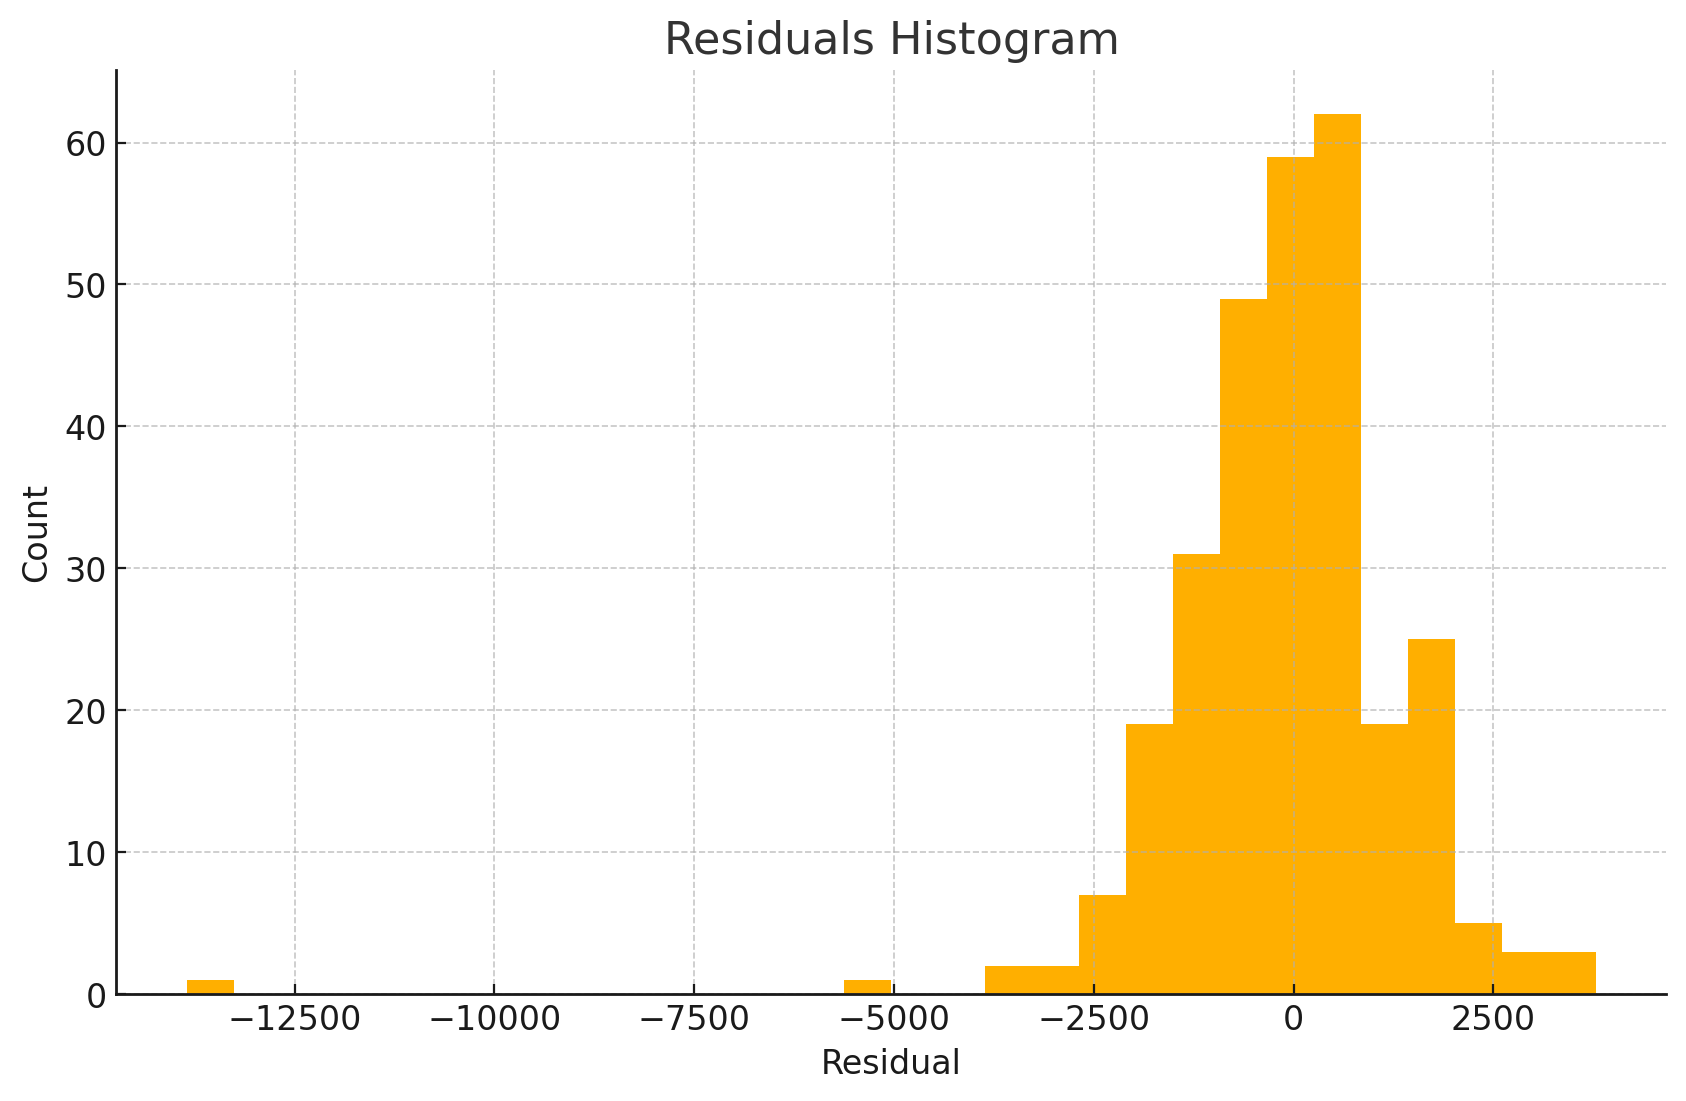

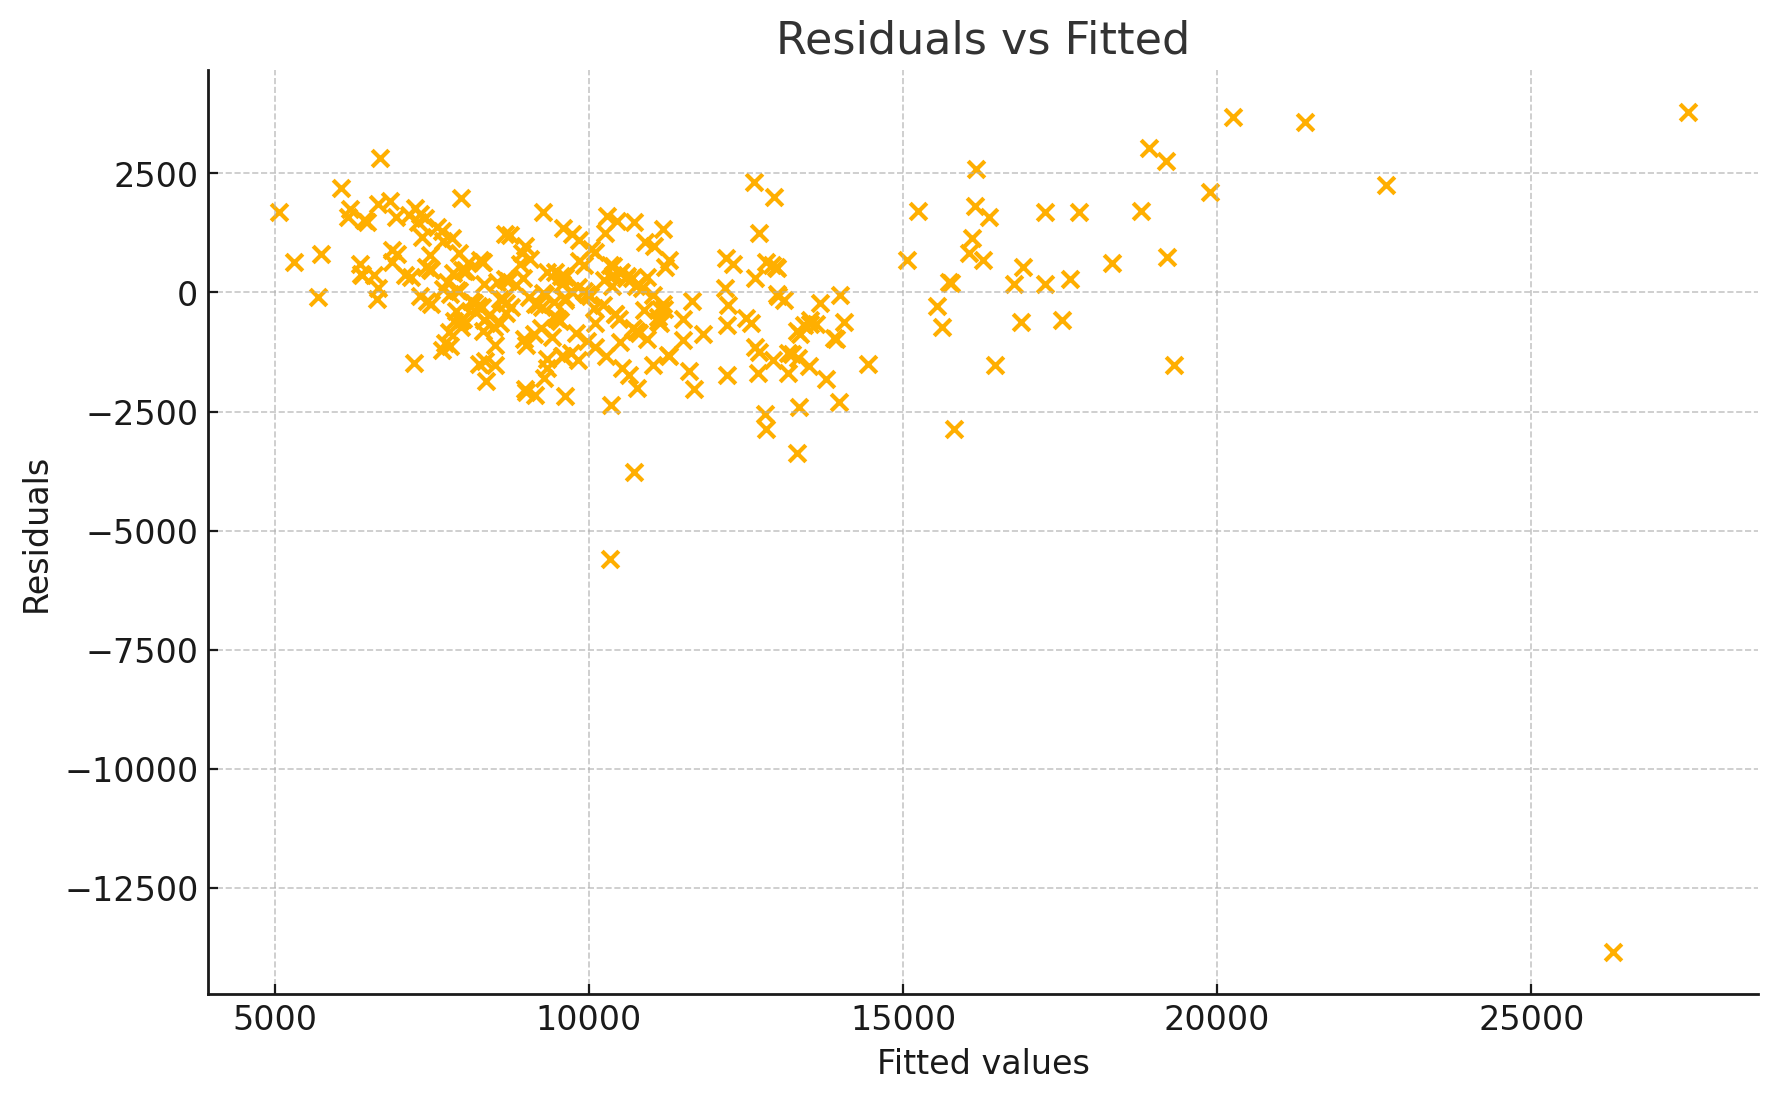

In [13]:
# Choose the best performing of lin1/lin2/lin3 by RMSE
metrics = [('lin1', rmse1, pred1, X_test), ('lin2', rmse2, pred2, X_test_vif), ('lin3', rmse3, pred3, X_test_fe)]
best_name, best_rmse, best_pred, X_test_best = sorted(metrics, key=lambda x: x[1])[0]
print("Best base linear model:", best_name, "RMSE:", best_rmse)

residuals = y_test.values - pred1 if best_name=='lin1' else (y_test.values - pred2 if best_name=='lin2' else y_test_fe.values - pred3)

# Residual histogram
plt.figure()
plt.hist(residuals, bins=30)
plt.title("Residuals Histogram")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# Residuals vs Fitted
fitted = pred1 if best_name=='lin1' else (pred2 if best_name=='lin2' else pred3)
plt.figure()
plt.scatter(fitted, residuals)
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

## 10) Model comparison — metrics

In [14]:
import pandas as pd
summary = pd.DataFrame({
    'Model':['Linear_All','Linear_VIF_Reduced','Linear_FE','Ridge','Lasso'],
    'RMSE':[rmse1, rmse2, rmse3, rmse_ridge, rmse_lasso],
    'R2':[r21, r22, r23, r2_ridge, r2_lasso]
}).sort_values('RMSE')
summary

,Model,RMSE,R2
3,Ridge,1451.580540,0.842081
4,Lasso,1481.648274,0.835471
1,Linear_VIF_Reduced,1482.585606,0.835262
0,Linear_All,1484.265415,0.834889
2,Linear_FE,1530.384299,0.824469


## 11) Interview questions — short answers

**Q1. What is Normalization & Standardization and how is it helpful?**

- **Normalization** rescales features to a fixed range (e.g., 0–1) and is helpful when features have different units/scales and algorithms use distances or regularization magnitudes.
- **Standardization** centers to mean 0 and variance 1 (z-score). It preserves outliers better and is preferred for linear models with regularization (Ridge/Lasso) and for interpreting coefficients.

**Q2. What techniques address multicollinearity in MLR?**

- Remove or combine highly correlated predictors (based on correlation/VIF)
- Use dimensionality reduction (PCA)
- Apply regularization (Ridge more than Lasso for multicollinearity)
- Collect more data or domain-driven feature selection.
